# The Project

A geology research company wants to create a tool for identifying interesting patterns in their imagery data. They will provide an image of interest and the ML model should return the top "N" similar images.

There are 6 different types of rocks: • andesite • gneiss • marble • quartzite • rhyolite • schist

## Approach:

 - We first need to identify which of the categories the input image belongs to
 - Once that is identified we'll select "N" similar images from the corresponding folder
 - For obtaining similar images we'll use the "Structural Similarity Index" (SSIM). The SSIM values range from 0 to 1, 1 being a perfect match

## Define the packages to be used

In [263]:
import split_folders
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob as glob
import random
import pickle
import cv2
from skimage.metrics import structural_similarity as ssim

# Packages for deep learning
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json

##### Set the working directory

In [5]:
os.chdir(r'C:\Users\amitr\Desktop\Amazon Case Study\geological_similarity\Data')

## Splitting the data into Train, Validation and Test folders

The given images are currently in six different folders as per the image classes:

**geological_similarity** (folder)
- andesite
- gneiss
- marble
- quartzite
- rhyolite
- schist
    
Let us start by first creating the Train, Validation and Test sets. We'll keep the ratio as 80% : 10% : 10%.

This will split the images into **three** folders, with **six** subfolders for each of the image classes. This is done for building/evaluating the model
 - "train" (80%)
 - "val" (10%)
 - "test" (10%)

In [4]:
Input = 'geological_similarity'
split_folders.ratio(Input, output="Data", seed=1337, ratio=(.8, .1, .1))

Copying files: 29998 files [00:22, 1328.26 files/s]


## Define the image classes for easy reference later

In [6]:
IMAGE_CLASSES = ['andesite','gneiss','marble','quartzite','rhyolite','schist']

## Show 5 sample images for each type of rock

In [7]:
def Show_Samples(folder, N=5):
    fig, ax = plt.subplots(1,N, figsize=(12,12))

    multipleImages = glob.glob(folder + '\**')
    rand_imgs = random.sample(multipleImages, N)

    for i in range(N):
        ax[i].imshow(mpimg.imread(rand_imgs[i]))
   
    ax[0].set_title(folder.split('/')[1])
    plt.show()

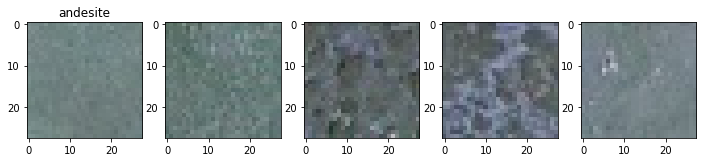

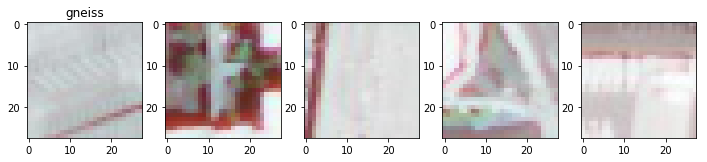

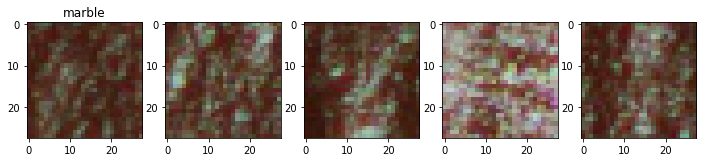

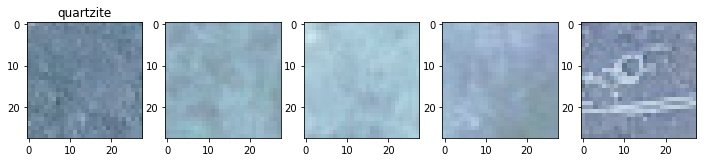

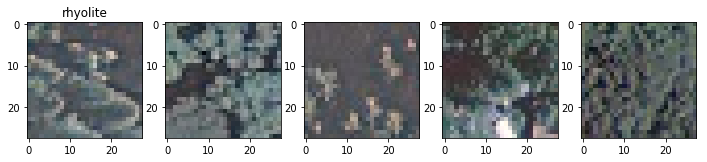

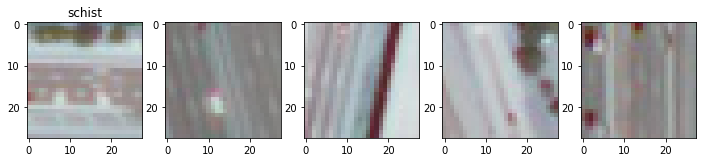

In [9]:
for i in IMAGE_CLASSES:
    Show_Samples('train/' + i)

## Check the size of images in each class

This is being done to confirm if all the images are the same dimensions or if there are any variations in the image sizes

In [10]:
def Get_Image_Sizes(folder):

    multipleImages = glob.glob('train\\' + folder + '\**')

    img_sizes = []
    for i in multipleImages:
        img = cv2.imread(i)
        img_sizes.append(img.shape)

    print ("Image sizes for {} : {}".format(folder, set(img_sizes)))

In [11]:
for i in IMAGE_CLASSES:
    Get_Image_Sizes(i)

Image sizes for andesite : {(28, 28, 3)}
Image sizes for gneiss : {(28, 28, 3)}
Image sizes for marble : {(28, 28, 3)}
Image sizes for quartzite : {(28, 28, 3)}
Image sizes for rhyolite : {(28, 28, 3)}
Image sizes for schist : {(28, 28, 3)}


We can see that all the images in all the folders have the same dimensions - (28,28,3)

## Model Creation

Define the input parameters to be used for the data generators and model building

In [81]:
IMG_SIZE = 28
BATCH_SIZE = 100

#### Create the data generators

In [82]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,                  
                                   width_shift_range = 0.2,                  
                                   height_shift_range = 0.2,                  
                                   shear_range = 0.2,                  
                                   zoom_range = 0.2,                     
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

#----------------------------------------------------------------------------

train_generator = train_datagen.flow_from_directory('train',
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    color_mode='rgb',
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory('val',
                                                               target_size=(IMG_SIZE, IMG_SIZE),
                                                               color_mode='rgb',
                                                               batch_size = BATCH_SIZE,
                                                               class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory('test',
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    color_mode='rgb',
                                                    batch_size = 1,
                                                    class_mode = 'categorical')


Found 23998 images belonging to 6 classes.
Found 2999 images belonging to 6 classes.
Found 3001 images belonging to 6 classes.


### Define the Convolutional Neural Network

I have tried using Transfer Learning using models like VGG16, ResNet etc. but the accuracy was really bad. That is because those models were trained on real-world images which were very different from the geological images we are training on. Hence a custom architecture, which learns from the given images, performs much better.

The layes used are:

 - Convolution layer (64 units)
 - Convolution layer (32 units)
 - MaxPooling
 - Flatten
 - Dense layer (32 units)
 - Dropout layer (to reduce overfitting)
 - Dense layer (64 units)
 - Dropout layer (to reduce overfitting)
 - Dense layer (6 units, with a 'sigmoid' activation function to predict the 6 classes of images)
 
For compiling the models we will use the "adam" optimizer. Since there are more than two classes, hence the loss function used is "categorical-crossentropy". The metric would be "accuracy"

In [116]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [124]:
history = model.fit_generator(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 240 steps, validate for 30 steps
Epoch 1/20
240/240 - 14s - loss: 0.0699 - accuracy: 0.9762 - val_loss: 0.0694 - val_accuracy: 0.9740
Epoch 2/20
240/240 - 14s - loss: 0.0759 - accuracy: 0.9737 - val_loss: 0.0856 - val_accuracy: 0.9700
Epoch 3/20
240/240 - 14s - loss: 0.0775 - accuracy: 0.9732 - val_loss: 0.0699 - val_accuracy: 0.9760
Epoch 4/20
240/240 - 14s - loss: 0.0753 - accuracy: 0.9744 - val_loss: 0.1144 - val_accuracy: 0.9597
Epoch 5/20
240/240 - 14s - loss: 0.0784 - accuracy: 0.9717 - val_loss: 0.0599 - val_accuracy: 0.9777
Epoch 6/20
240/240 - 14s - loss: 0.0716 - accuracy: 0.9762 - val_loss: 0.1039 - val_accuracy: 0.9610
Epoch 7/20
240/240 - 14s - loss: 0.0722 - accuracy: 0.9747 - val_loss: 0.0587 - val_accuracy: 0.9797
Epoch 8/20
240/240 - 14s - loss: 0.0756 - accuracy: 0.9741 - val_loss: 0.0671 - val_accuracy: 0.9757
Epoch 9/20
240/240 - 14s - loss: 0.0681 - accuracy: 0.9769 - val_loss: 0.0589 - val_accuracy: 0.979

In [255]:
train_accuracy = round(np.mean(history.history['accuracy']) * 100, 2)
val_accuracy = round(np.mean(history.history['val_accuracy']) * 100, 2)
print("The average training accuracy is : {}%".format(train_accuracy))
print("The average validation accuracy is : {}%".format(val_accuracy))

The average training accuracy is : 97.51%
The average validation accuracy is : 97.37%


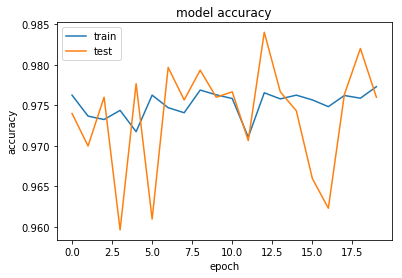

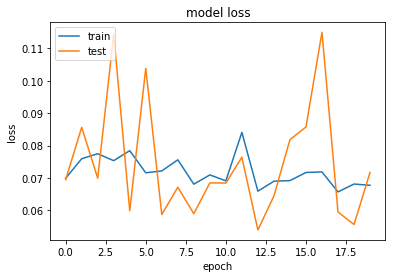

In [125]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### See the model summary

In [126]:
model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           multiple                  1792      
_________________________________________________________________
max_pooling2d_73 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_74 (Conv2D)           multiple                  18464     
_________________________________________________________________
max_pooling2d_74 (MaxPooling multiple                  0         
_________________________________________________________________
flatten_37 (Flatten)         multiple                  0         
_________________________________________________________________
dense_92 (Dense)             multiple                  25632     
_________________________________________________________________
dropout_71 (Dropout)         multiple                

#### Save the model for later use

In [149]:
path = r'C:\Users\amitr\Desktop\Amazon Case Study\geological_similarity\Models'
os.chdir(path)

In [150]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

    # serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


#### Load the saved model (use if starting a fresh kernel)

In [44]:
with open(path + '\model.JSON', 'r') as json_file:
    loaded_model= json_file.read()

#load the model architecture 
model = model_from_json(loaded_model)

print("Loaded the model from disk\n\n")
model.summary()

Loaded the model from disk


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           multiple                  896       
_________________________________________________________________
conv2d_81 (Conv2D)           multiple                  18496     
_________________________________________________________________
max_pooling2d_49 (MaxPooling multiple                  0         
_________________________________________________________________
dropout_30 (Dropout)         multiple                  0         
_________________________________________________________________
flatten_26 (Flatten)         multiple                  0         
_________________________________________________________________
dense_69 (Dense)             multiple                  1179776   
_________________________________________________________________
dropout_31 (Dropout)    

## Test the model on single images

In [370]:
def read_geologic_image(file_path):

    image = load_img(file_path, target_size=(28, 28)) 
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image /= 255. 
    return image

def Predict_Class(file):
    
    test_img = read_geologic_image(file)
    
    input_class = file[:-4].split('\\')[-2]

    pred = model.predict(test_img)
    pred_class = IMAGE_CLASSES[np.argmax(pred)]
    
    return input_class, pred_class
    
def Show_Prediction(file):
    input_class, pred_class = Predict_Class(file)
    print("Input Class : {}       Predicted Class : {}".format(input_class, pred_class))

We'll take one sample image each from the various "test" sub-folders as those are the ones the model has not seen yet and check if it is able to predict the image classes correctly

In [371]:
Path = r'C:\Users\amitr\Desktop\Amazon Case Study\geological_similarity\Data\test'

Show_Prediction(Path + r'\gneiss\8V7GK.jpg')
Show_Prediction(Path + r'\marble\1IJ99.jpg')
Show_Prediction(Path + r'\quartzite\1QJ19.jpg')
Show_Prediction(Path + r'\andesite\01ITR.jpg')
Show_Prediction(Path + r'\rhyolite\4MAHE.jpg')
Show_Prediction(Path + r'\schist\7D6MS.jpg')

Input Class : gneiss       Predicted Class : gneiss
Input Class : marble       Predicted Class : marble
Input Class : quartzite       Predicted Class : quartzite
Input Class : andesite       Predicted Class : andesite
Input Class : rhyolite       Predicted Class : rhyolite
Input Class : schist       Predicted Class : schist


As we can see, the model is very accurate in predicting the class for unseen images :) 

### Get Confusion Matrix for all the Test images

Let us now evaluate the model on all the test images and see the overall accuracy on unseen test data

In [244]:
Test_Folders = glob.glob(r'C:\Users\amitr\Desktop\Amazon Case Study\geological_similarity\Data\test\**')

In [156]:
image_data = []
for i in Test_Folders:
    test_class = i.split('\\')[-1]
    image_list = glob.glob(i + '\**')
    for j in image_list:
        img = read_image(j)
        pred = model.predict(img)
        pred_class = IMAGE_CLASSES[np.argmax(pred)]
        image_data.append([test_class,pred_class])
        
output = pd.DataFrame(data=image_data, columns=['Actual','Predicted'])
output.head()

,Actual,Predicted
0,andesite,andesite
1,andesite,andesite
2,andesite,andesite
3,andesite,andesite
4,andesite,andesite


In [259]:
test_accuracy = len(output[output['Actual']==output['Predicted']]) / len(output)
test_accuracy = round(test_accuracy * 100, 2)
print("\nThe test accuracy is : {}%".format(test_accuracy))

pd.crosstab(index=output['Actual'], columns=output['Predicted'])


The test accuracy is : 97.63%


Predicted,andesite,gneiss,marble,quartzite,rhyolite,schist
Actual,,,,,,
andesite,480,0,0,5,13,2
gneiss,0,493,0,0,0,7
marble,0,0,501,0,0,0
quartzite,28,0,0,463,2,7
rhyolite,1,0,0,1,498,0
schist,0,5,0,0,0,495


We can see that the overall accuracy is very good and the model is able to accurately predict almost all the test images

# Returning "N" similar images to the given image

Now that we are able to classify the input images, let us use the "Structural Similarity Index" to obtain the top 'N' matches for a given image.

Based on the predicted class of the image we'll search in the corresponding 'folder' name to find the most similar images from that folder.

### Demo of the Structural Similarity Index

Let us first do a quick demo to see that the Structural Similarity Index is giving the right results

I have deliberately smudged a corner of one of the images and saved it as a new image. We have 6 images in a folder. Let us see if the SSIM index gives us the smudged image as the closest match

In [427]:
def Show_Image(file, shape=(28,28)):

    img = cv2.imread(file)
    img = cv2.resize(img, shape)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return RGB_img

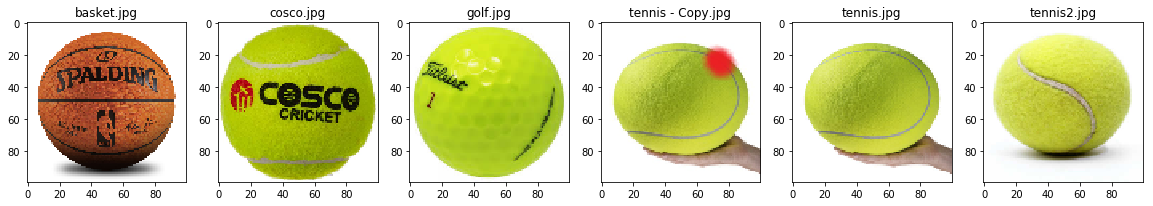

In [428]:
os.chdir(r'C:\Users\amitr\Desktop\Temp')

AllImages = glob.glob(r'C:\Users\amitr\Desktop\Temp\**')

Images = []
for file in AllImages:
    Images.append(Show_Image(file, (100,100)))
    
fig, ax = plt.subplots(1,len(Images), figsize=(20,20))

for i in range(len(Images)):
    ax[i].imshow(Images[i])
    ax[i].set_title(AllImages[i].split('\\')[-1])

plt.show()

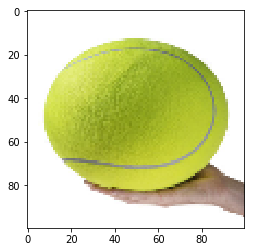

In [432]:
# Set the size of the images to compare. All images have to be the same size for comparison
INPUT_SHAPE = (100,100)

# Read in the imput image
input_filename = 'tennis.jpg'
input_image = Show_Image(input_filename, INPUT_SHAPE)

plt.imshow(input_image)
plt.show()

The closest match to the input image is :  tennis - Copy.jpg
The matching score is : 95.34%


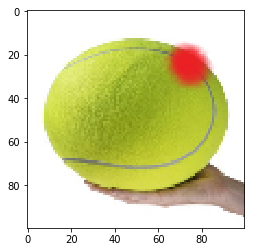

In [434]:
# Get the SSIM scores for all the images except the given image (if a file by the same name is found in that folder)

AllImages = glob.glob(r'C:\Users\amitr\Desktop\Temp\**')
AllImages = [x.split('\\')[-1] for x in AllImages]

SSIM_Scores = []

for file in AllImages:
    
    if file == input_filename:
        continue

    to_compare = Show_Image(file,INPUT_SHAPE)

    score = ssim(input_image, to_compare, multichannel=True)
    SSIM_Scores.append([file, score])
    
SSIM_Scores.sort(key = lambda x : x[1], reverse=True)

closest_match = SSIM_Scores[0][0].split('\\')[-1]
match_score = round(SSIM_Scores[0][1] * 100, 2)

print("The closest match to the input image is : ", closest_match)
print("The matching score is : {}%".format(match_score))

plt.imshow(Show_Image(SSIM_Scores[0][0], INPUT_SHAPE))
plt.show()

We can see that the Structural Similarity Index is able to get the right closest match for the given image

## Get the closest 5 images for the given image

Now let us use the same concept to get the top 5 matches for any given image after predicting the right class (i.e the folder name)

We will use the original folder where ALL the images are stored (not the train/val/test split folders)

In [495]:
# Set the path
path = r'C:\Users\amitr\Desktop\Amazon Case Study\geological_similarity\geological_similarity'

In [500]:
def Get_Best_Matches(input_filename, N_matches=5):
 
    #--------------------------------------------------
    # Get the predicted class for the input image
    #--------------------------------------------------

    input_class, pred_class = Predict_Class(input_filename)

    # Show the input and predicted classes
    print("Input Class : {}       Predicted Class : {}".format(input_class, pred_class))

    # Show the input image
    plt.figure(figsize=(2,2))
    input_image = Show_Image(input_filename)
    plt.imshow(input_image)
    plt.show()
    

    #------------------------------------------------------------------------------
    # Calculate the SSIM scores for all the images in the predicted class (folder)
    #------------------------------------------------------------------------------
    
    AllImages = glob.glob(path + '\\' + pred_class + '\\**')

    SSIM_Scores = []

    for file in AllImages:

        if file == input_filename:
            continue

        to_compare = Show_Image(file)

        score = ssim(input_image, to_compare, multichannel=True)
        SSIM_Scores.append([file, score])

    SSIM_Scores.sort(key = lambda x : x[1], reverse=True)
    

    #----------------------------------------------------------------------
    # Show the top "N" matches
    #----------------------------------------------------------------------
        
    print ("\n\nShowing the top {} matches".format(N_matches))
    
    top_matches = SSIM_Scores[:N_matches]

    fig, ax = plt.subplots(1,N_matches, figsize=(10,10))

    for i in range(N):
        img = Show_Image(top_matches[i][0])
        score = round(top_matches[i][1] * 100,2)
        ax[i].imshow(img)
        ax[i].set_title('score : ' + str(score))

    fig.tight_layout()
    plt.show()

Let us now test the quality of matches for a given image

Input Class : marble       Predicted Class : marble


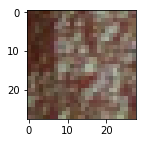



Showing the top 5 matches


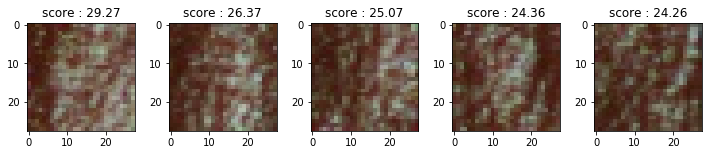

In [521]:
Get_Best_Matches(path + "\\marble\\0ZPAW.jpg")

Input Class : gneiss       Predicted Class : gneiss


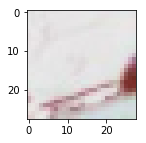



Showing the top 5 matches


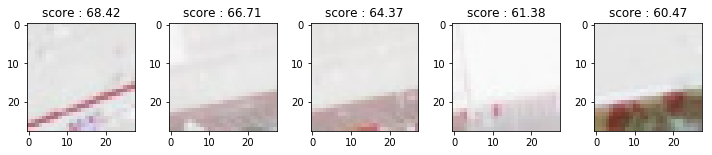

In [511]:
Get_Best_Matches(path + "\\gneiss\\1VLJR.jpg")

Input Class : andesite       Predicted Class : andesite


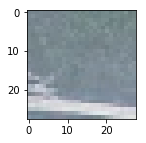



Showing the top 5 matches


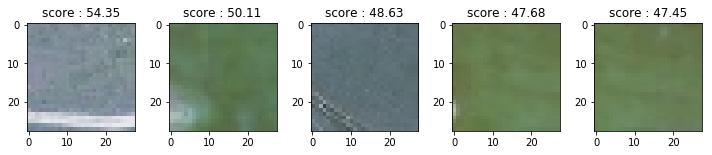

In [515]:
Get_Best_Matches(path + "\\andesite\\0KQH2.jpg")

## Summary

This project shows a simple way to get the best matches for a given image. There could be other much more complicated and better methods. However, with my limited knowledge of image processing this was my first shot. Hope you liked it :)